In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
file_names = list()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_names.append(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/furniture-price-prediction/Furniture Price Prediction.csv


In [2]:
furniture_data = pd.read_csv(file_names[0])

# Exploring the Data

In [3]:
# Top 5 values of the data
furniture_data.head()

,furniture,type,url,rate,delivery,sale,price
0,Bed side table with storage shelf,Home Decor Center,https://www.jumia.com.eg//ar/home-decor-center...,3.3,172.14,72%,2500.0
1,Bed side table with storage shelf,Modern Home,https://www.jumia.com.eg//ar/modern-home-bedsi...,0.0,172.14,54%,1200.0
2,Modern Zigzag TV Table,Modern Home,https://www.jumia.com.eg//ar/generic-zigzag-tv...,0.0,172.14,18%,1099.0
3,Bedside table with storage shelf,Modern Home,https://www.jumia.com.eg//ar/modern-home-bedsi...,0.0,172.14,58%,1200.0
4,Wall Mounted TV Unit with Cabinet TV Stand Uni...,Modern Home,https://www.jumia.com.eg//ar/modern-home-wall-...,5.0,52.44,54%,1400.0


In [4]:
# Data's number of rows, columns, data types and missing values
furniture_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   furniture  2000 non-null   object 
 1   type       2000 non-null   object 
 2   url        2000 non-null   object 
 3   rate       2000 non-null   float64
 4   delivery   2000 non-null   float64
 5   sale       2000 non-null   object 
 6   price      1961 non-null   float64
dtypes: float64(3), object(4)
memory usage: 109.5+ KB


In [5]:
# Categorical data's value count
features_cat = ["furniture", "type", "sale"]
for fe in features_cat:
    print("Feature name: " + fe)
    print(furniture_data[fe].value_counts())
    print("\n")

Feature name: furniture
Modern capton bed, cm wood                          29
cm TV table                                         27
Corner bed                                          22
Sofa bed                                            21
Mora mattress, ten years guarantee, size is high    19
                                                    ..
Living room                                          1
Home Gallery Wall Shelf x x White                    1
New Primo Sofa Bed                                   1
In Home Bed Sofa - 120 *190 Cm -  Teal               1
Coffee table + side table                            1
Name: furniture, Length: 1224, dtype: int64


Feature name: type
Modern Home                                                           678
Rango                                                                  81
Marfy Touch                                                            57
General                                                                51
Artistico 

In [6]:
# Getting more info about numerical features in the data 
furniture_data.describe()

,rate,delivery,price
count,2000.000000,2000.000000,1961.000000
mean,0.743450,142.673285,2910.418195
std,1.611737,139.339128,4002.917206
min,0.000000,10.830000,13.400000
25%,0.000000,52.440000,740.000000
50%,0.000000,172.140000,1900.000000
75%,0.000000,172.140000,4000.000000
max,5.000000,2409.900000,55000.000000


In [7]:
# Numerical feature's histogram
import matplotlib.pyplot as plt

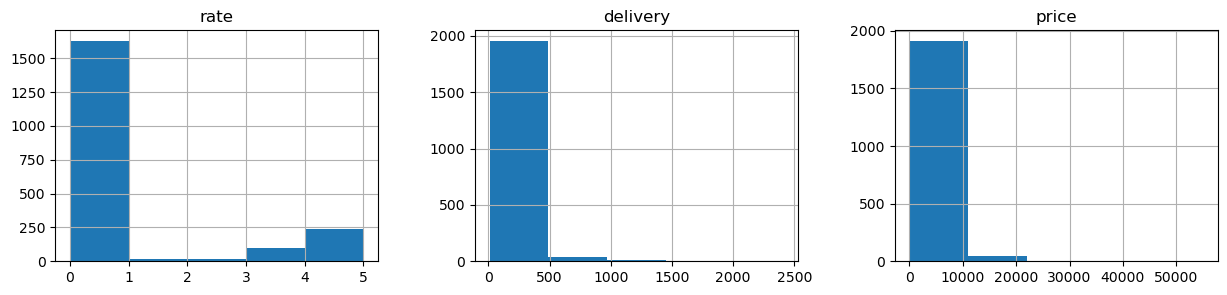

In [8]:
furniture_data.hist(bins=5, layout=(1,3), figsize=(15,3))
plt.show()

# Pre processing the data

In [9]:
furniture_copy = furniture_data.copy()

In [10]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder

In [11]:
def data_cleaning(furniture_copy):
    furniture_copy.dropna(subset=["price"], inplace=True)
    furniture_copy.drop(labels="url", axis=1, inplace=True)
    rate_col = furniture_copy[furniture_copy.rate != 0]
    avg_rate = rate_col["rate"].mean()
    furniture_copy["rate"] = furniture_copy["rate"].replace([0], avg_rate)
    furniture_copy["sale"] = furniture_copy["sale"].str.replace('\D', '', regex=True)
    furniture_copy["sale"] = furniture_copy["sale"].astype(int)
    
    # categorcal data
    attribs_cat = ["furniture", "type"]
    encoder=TargetEncoder(cols=attribs_cat)
    df = encoder.fit_transform(furniture_copy[attribs_cat],furniture_copy["price"])
    furniture_copy["furniture"] = df["furniture"]
    furniture_copy["type"] = df["type"]
    
    return furniture_copy

In [12]:
furniture_copy = data_cleaning(furniture_copy)

In [13]:
furniture_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1961 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   furniture  1961 non-null   float64
 1   type       1961 non-null   float64
 2   rate       1961 non-null   float64
 3   delivery   1961 non-null   float64
 4   sale       1961 non-null   int64  
 5   price      1961 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 171.8 KB


# Looking for co-relations

In [14]:
corr_mtrix = furniture_copy.corr()

In [15]:
corr_mtrix["price"].sort_values(ascending=False)

price        1.000000
furniture    0.881475
type         0.635377
delivery     0.101149
rate        -0.021114
sale        -0.178771
Name: price, dtype: float64

**-> first 3 rows are giving higher co-relation because<br>
-> they are calculated from the price feature, so we<br>
-> need to avoid this relation**<br>

# Plotting the co-relations

In [16]:
from pandas.plotting import scatter_matrix

array([[<AxesSubplot:xlabel='price', ylabel='price'>,
        <AxesSubplot:xlabel='delivery', ylabel='price'>,
        <AxesSubplot:xlabel='rate', ylabel='price'>,
        <AxesSubplot:xlabel='sale', ylabel='price'>],
       [<AxesSubplot:xlabel='price', ylabel='delivery'>,
        <AxesSubplot:xlabel='delivery', ylabel='delivery'>,
        <AxesSubplot:xlabel='rate', ylabel='delivery'>,
        <AxesSubplot:xlabel='sale', ylabel='delivery'>],
       [<AxesSubplot:xlabel='price', ylabel='rate'>,
        <AxesSubplot:xlabel='delivery', ylabel='rate'>,
        <AxesSubplot:xlabel='rate', ylabel='rate'>,
        <AxesSubplot:xlabel='sale', ylabel='rate'>],
       [<AxesSubplot:xlabel='price', ylabel='sale'>,
        <AxesSubplot:xlabel='delivery', ylabel='sale'>,
        <AxesSubplot:xlabel='rate', ylabel='sale'>,
        <AxesSubplot:xlabel='sale', ylabel='sale'>]], dtype=object)

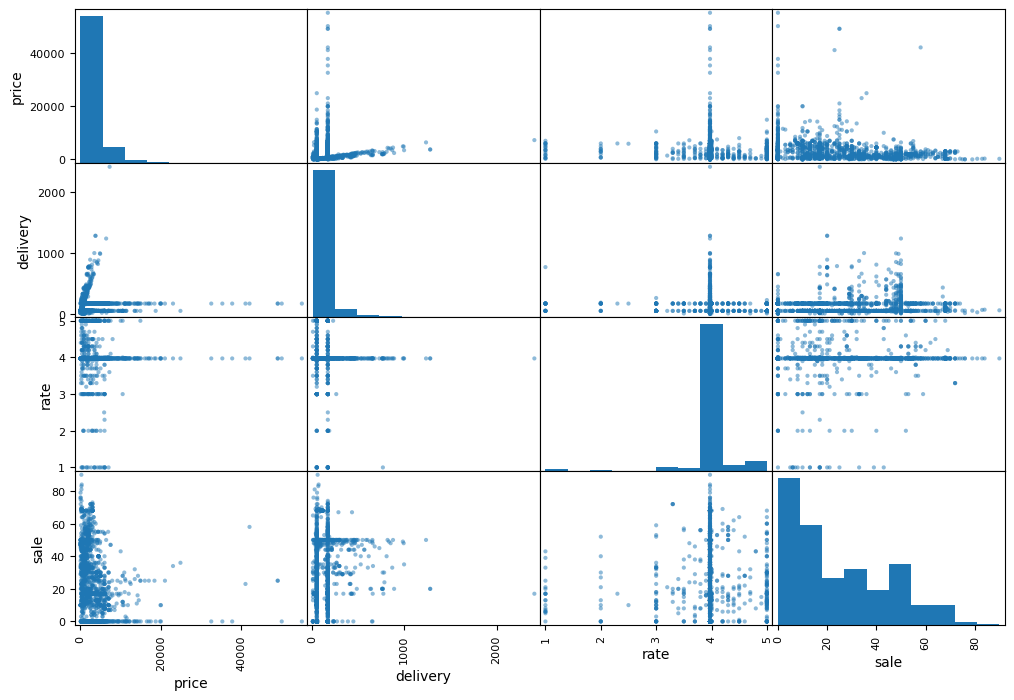

In [17]:
attributes = ["price", "delivery", "rate", "sale"]
scatter_matrix(furniture_copy[attributes], figsize=(12,8))

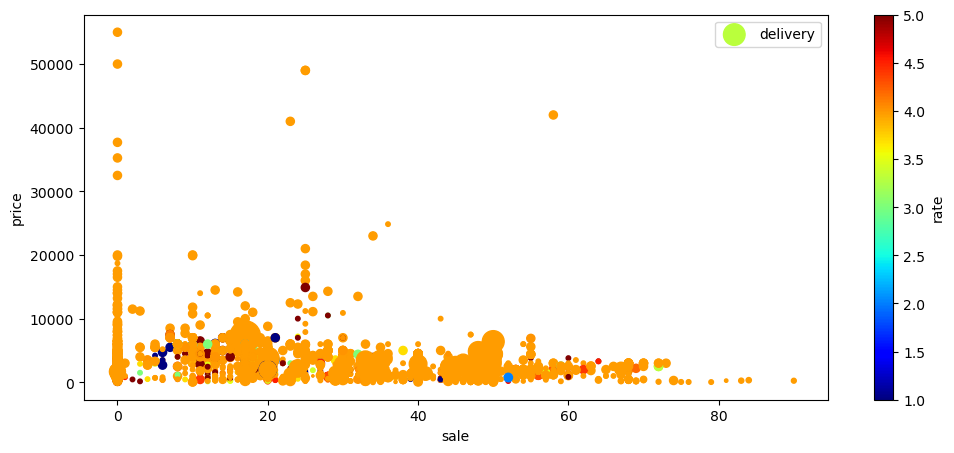

In [18]:
furniture_copy.plot(kind="scatter", x="sale", y="price", alpha=1,
                 s=furniture_copy["delivery"]/5, label="delivery", figsize=(12,5),
                 c="rate", cmap="jet", colorbar=True)
plt.legend()
plt.show()

# Scaling the data

In [19]:
features = furniture_copy.drop(labels="price", axis=1)
features

,furniture,type,rate,delivery,sale
0,2574.128948,2847.022840,3.300000,172.14,72
1,2574.128948,2699.205224,3.972703,172.14,54
2,2386.826865,2699.205224,3.972703,172.14,18
3,2377.337947,2699.205224,3.972703,172.14,58
4,2656.695707,2699.205224,5.000000,52.44,54
...,...,...,...,...,...
1995,2744.085154,2744.085154,3.972703,656.28,0
1996,4021.490155,7944.135893,3.972703,172.14,0
1997,2575.590360,1624.668981,3.972703,52.44,0
1998,4511.148141,4928.389499,3.972703,172.14,9


In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scalar = MinMaxScaler()
features = scalar.fit_transform(features)

In [22]:
features[1]

array([0.02917426, 0.20253939, 0.74317568, 0.06723855, 0.6       ])

# Spliting the data into train test split

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, furniture_copy["price"], test_size=0.2, random_state=42)

# Select and train a model

In [24]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [26]:
lin_reg = LinearRegression()

In [27]:
lin_reg.fit(X_train, y_train)
furniture_pred = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, furniture_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1843.7853451162055

In [28]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [2386.26819314 1520.63395956 1477.86749104 2200.26295646 2364.71604505
 1644.99570867 1776.98127139 1747.26610643 1264.98129115 2252.24754094]
Mean:  1863.6220563833926
Standard deviation:  385.00286106378746


In [29]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
tree_mse = mean_squared_error(y_test, furniture_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1843.7853451162055

In [30]:
tree_scores = cross_val_score(tree, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-lin_scores)
display_scores(tree_rmse_scores)

Scores:  [2386.26819314 1520.63395956 1477.86749104 2200.26295646 2364.71604505
 1644.99570867 1776.98127139 1747.26610643 1264.98129115 2252.24754094]
Mean:  1863.6220563833926
Standard deviation:  385.00286106378746


In [31]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [32]:
forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [ 856.0638331   545.68633578  583.14368771  505.50595725 1391.46006689
  851.58133041  918.01894729  570.29585801  394.45475325 2718.27022483]
Mean:  933.4480994514236
Standard deviation:  654.7437478806875


In [33]:
forest_pred = forest_reg.predict(X_test)
tree_pred = tree.predict(X_test)
lin_pred = lin_reg.predict(X_test)

In [34]:
print("r2 score for forest: ", + r2_score(forest_pred, y_test))
print("r2 score for tree: ", + r2_score(tree_pred, y_test))
print("r2 score for linear: ", + r2_score(lin_pred, y_test))

r2 score for forest:  0.8934239562669518
r2 score for tree:  0.8701514051375019
r2 score for linear:  0.7493785687247865


> **So, we can chooose "RandomForestRegressor" as our model**

# Fine tune model

In [35]:
# Grid Search
from sklearn.model_selection import GridSearchCV

In [36]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features':[2, 4, 5]},
    {'bootstrap':[False], 'n_estimators': [3, 10], 'max_features': [2, 3, 5]},
]

In [37]:
forest_reg = RandomForestRegressor()

In [38]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)

In [39]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 5],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 5],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [40]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [41]:
cvres = grid_search.cv_results_

In [42]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

1390.4745483506724 {'max_features': 2, 'n_estimators': 3}
1515.8691561505307 {'max_features': 2, 'n_estimators': 10}
1039.798724676877 {'max_features': 2, 'n_estimators': 30}
1222.454819878107 {'max_features': 4, 'n_estimators': 3}
1258.4385013628735 {'max_features': 4, 'n_estimators': 10}
1129.130557543253 {'max_features': 4, 'n_estimators': 30}
1329.5511228089626 {'max_features': 5, 'n_estimators': 3}
1190.6146297951345 {'max_features': 5, 'n_estimators': 10}
1185.8677535053923 {'max_features': 5, 'n_estimators': 30}
1270.7389597910337 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
1131.7555491893802 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
1220.0007327567596 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
1060.968188326164 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
1183.1135885084104 {'bootstrap': False, 'max_features': 5, 'n_estimators': 3}
1191.237476426347 {'bootstrap': False, 'max_features': 5, 'n_estimators': 10}


# Testing model

In [43]:
forest_reg = RandomForestRegressor(max_features=5, n_estimators=3)

In [44]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(max_features=5, n_estimators=3)

In [45]:
forest_pred = forest_reg.predict(X_test)
print("r2 score for forest: ", + r2_score(forest_pred, y_test))

r2 score for forest:  0.9189117415729703


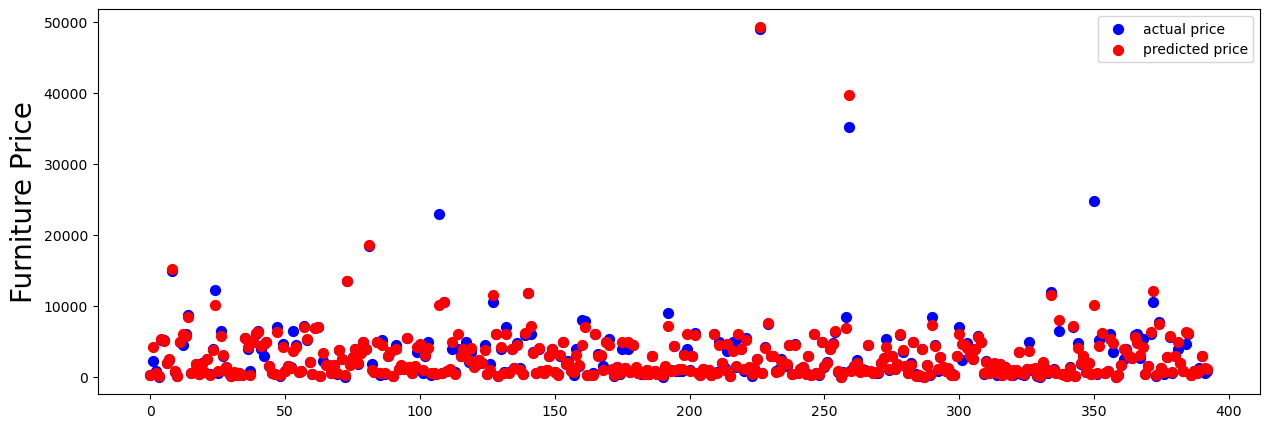

In [46]:
plt.figure(figsize=(15, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label="actual price", s=50) 
plt.scatter(range(len(y_test)), forest_pred, color='red', label="predicted price", s=50)
plt.ylabel("Furniture Price", fontsize=20)
plt.legend()
plt.show()